In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
import os

## Constantes

In [4]:
PATH_TRICHODERMA = "redes/Trichoderma_atroviride/"
PATH_SECUENCIAS_TRICHODERMA = "secuencias_prufer/trichoderma_atroviride/"
REDES_TRICHODERMA = {1:["Muestra1_M1T24h","Muestra1_M1T26h","Muestra1_M1T28h","Muestra1_M1T30h","Muestra1_M1T32h"],
    2:["Muestra2_M2T24h","Muestra2_M2T26h","Muestra2_M2T28h","Muestra2_M2T30h","Muestra2_M2T32h"],
    3:["Muestra3_M3T26h","Muestra3_M3T28h","Muestra3_M3T30h","Muestra3_M3T32h","Muestra3_M3T34h","Muestra3_M3T36h"],
    4:["Muestra4_M4T26h","Muestra4_M4T28h","Muestra4_M4T30h","Muestra4_M4T32h","Muestra4_M4T34h","Muestra4_M4T36h"],
    5:["Muestra5_M5T26h","Muestra5_M5T28h","Muestra5_M5T30h","Muestra5_M5T32h","Muestra5_M5T36h"]
}

In [5]:
PATH_NEUROSPORA = "redes/Neurospora_crassa/"
PATH_SECUENCIAS_NEUROSPORA = "secuencias_prufer/neurospora_crassa/"
REDES_NEUROSPORA = {1:["Muestra1_M1N17h","Muestra1_M1N18h","Muestra1_M1N20h","Muestra1_M1N22h","Muestra1_M1N24h"],
    2:["Muestra2_M2N18h","Muestra2_M2N20h","Muestra2_M2N22h","Muestra2_M2N24h"],
    3:["Muestra3_M3N17h","Muestra3_M3N18h","Muestra3_M3N20h","Muestra3_M3N22h","Muestra3_M3N24h"],
    4:["Muestra4_M4N17h","Muestra4_M4N18h","Muestra4_M4N20h","Muestra4_M4N22h","Muestra4_M4N24h"],
    5:["Muestra5_M5N18h","Muestra5_M5N20h","Muestra5_M5N22h","Muestra5_M5N24h"]
}


In [6]:
nodos_trichoderma = {1: [24, 68 , 84 , 148, 294],
                    2: [8, 16, 24, 62, 150],
                    3: [14, 42, 68, 160, 356, 788],
                    4: [18,24, 50,104, 268, 606],
                    5: [14,18,42,108,422]}
nodos_neurospora = {1: [42, 54 , 102 , 226, 663 ],
                    2: [44, 110, 226, 758,],
                    3: [6, 24, 50, 128, 338],
                    4: [58, 84, 202, 518, 1578],
                    5: [48, 100, 280, 790],
                    }

## Árbol balanceado

In [7]:
def generar_arbol_regular_balanceado(k=3, altura=2):
    G = nx.Graph()
    node_id = 0
    edges = []
    niveles = [[node_id]]
    node_id += 1

    for _ in range(altura):
        nivel_actual = []
        for padre in niveles[-1]:
            hijos = [node_id + i for i in range(k)]
            edges.extend((padre, h) for h in hijos)
            nivel_actual.extend(hijos)
            node_id += k
        niveles.append(nivel_actual)
    G.add_edges_from(edges)
    return G

In [8]:
def dibujar_arbol(G, titulo,pos, node_labels):
    nx.draw(G, pos, node_size=600)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=12, font_color='white')
    plt.title(titulo)
    plt.show()

# Etiquetado por centralidad

In [9]:
def etiquetado_por_centralidad(G, centralidad, weighted):
    if centralidad == 0:
        if weighted:
            centralidad = dict(G.degree(weight="weight"))
        else:
            centralidad = dict(G.degree())
    elif centralidad == 1:
        centralidad = nx.degree_centrality(G)
    elif centralidad == 2:
        centralidad = nx.eigenvector_centrality(G,weight="weight")
    elif centralidad == 3:
        if weighted:
            centralidad = nx.closeness_centrality(G, distance="weight")
        else:
            centralidad = nx.closeness_centrality(G)
    elif centralidad == 4:
        if weighted:
            centralidad = nx.betweenness_centrality(G, weight="weight")
        else:
            centralidad = nx.betweenness_centrality(G)
    elif centralidad == 5:
        if weighted:
            centralidad = nx.pagerank(G, weight="weight")
        else:
            centralidad = nx.pagerank(G)
    elif centralidad == 6:
        if weighted:
            centralidad = nx.katz_centrality(G, weight="weight")
        else:
            centralidad = nx.katz_centrality(G)
    elif centralidad == 7:
        if weighted:
            centralidad = nx.current_flow_betweenness_centrality(G, weight="weight")
        else:
            centralidad = nx.current_flow_betweenness_centrality(G)
    elif centralidad == 8:
        if weighted:
            centralidad = nx.load_centrality(G, weight="weight")
        else:
            centralidad = nx.load_centrality(G)
    elif centralidad == 9:
        if weighted:
            centralidad = nx.harmonic_centrality(G, distance="weight")
        else:
            centralidad = nx.harmonic_centrality(G)
    else:
        return None
    centralidad_ordenada = sorted(centralidad.items(), key=lambda item: item[1])
    #print(centralidad_ordenada)
    node_labels = {centralidad_ordenada[i][0]:i for i in range(len(centralidad_ordenada))}
    return node_labels

## Lee las redes

In [10]:
def prufer_sequence_from_tree(edges):
    """
    Obtiene la sucesión de Prüfer de un árbol dado.

    Parámetros:
      - edges: lista de tuplas (u, v) que representan las aristas de un árbol etiquetado.

    Retorna:
      - prufer_seq: lista que representa la sucesión de Prüfer del árbol.
    """
    # 1. Determinar el conjunto de nodos y el número total de vértices.
    nodes = set()
    for u, v in edges:
        nodes.add(u)
        nodes.add(v)
    n = len(nodes)

    # 2. Crear la lista de adyacencia y calcular el grado de cada nodo.
    adj = {node: [] for node in nodes}
    degree = {node: 0 for node in nodes}

    for u, v in edges:
        adj[u].append(v)
        adj[v].append(u)
        degree[u] += 1
        degree[v] += 1

    # 3. Inicializar un heap (min-heap) con todas las hojas (nodos con grado 1)
    heap = []
    for node in nodes:
        if degree[node] == 1:
            heapq.heappush(heap, node)

    prufer_seq = []

    # 4. Realizar n-2 iteraciones para construir la sucesión de Prüfer.
    for _ in range(n - 2):
        # a) Extraer la hoja de menor etiqueta.
        leaf = heapq.heappop(heap)

        # b) Su hoja tendrá un único vecino; se toma el primer (y único) de su lista de adyacencia.
        neighbor = adj[leaf][0]
        prufer_seq.append(neighbor)

        # c) Actualizar el grado del vecino, eliminando la conexión con la hoja.
        degree[neighbor] -= 1
        adj[neighbor].remove(leaf)

        # d) La hoja se elimina del árbol; (podríamos marcarla con grado 0).
        degree[leaf] = 0

        # e) Si el vecino ahora es una hoja (grado 1), se agrega al heap.
        if degree[neighbor] == 1:
            heapq.heappush(heap, neighbor)

    return prufer_seq

In [11]:
def muestra_secuencias(secuencias, etiquetas, tipo_hongo):
    plt.figure(figsize=(8, 8))
    for i, seq in enumerate(secuencias):
        #plt.plot(seq, label=etiquetas[i], marker=".", linestyle="-")
        plt.scatter(range(len(seq)), seq, label=etiquetas[i], marker=".", linestyle="-")
    plt.xlabel("Índice en la secuencia")
    plt.ylabel("Etiqueta del vértice")
    if weighted:
        titulo = tipo_hongo + "_" + TIPO[CENTRALIDAD] + "_weighted"
        p_sec = path_secuencias + TIPO[CENTRALIDAD] + "_weighted/"
    else:
        titulo = tipo_hongo + "_" + TIPO[CENTRALIDAD] + "_unweighted"
        p_sec = path_secuencias + TIPO[CENTRALIDAD] + "_unweighted/"
    plt.title(titulo)
    plt.legend()
    plt.grid()
    # Crear la carpeta si no existe
    os.makedirs(p_sec, exist_ok=True)
    plt.savefig(p_sec + titulo + "_m" + str(muestra) + ".png")
    plt.show()


In [12]:
#---- Trichoderma atroviride ---
#path_red = PATH_TRICHODERMA
#redes = REDES_TRICHODERMA
#titulo = "Trichoderma_Atroviride"
#nodos_red = nodos_trichoderma
#path_secuencias = PATH_SECUENCIAS_TRICHODERMA

#---- Neurospora crassa ---
path_red = PATH_NEUROSPORA
redes = REDES_NEUROSPORA
titulo = "Neurospora_Crassa"
nodos_red = nodos_neurospora
path_secuencias = PATH_SECUENCIAS_NEUROSPORA

# Centralidades que no considerar pesos: Degree centrality,
# Centralidades que no convergen con pesos: Katz
# No converge sin pesos :  Eigenvector
weighted = True
CENTRALIDAD = 3
TIPO = {0: "Degree", 1:"Degree centrality", 2: "Eigenvector", 3: "Closeness", 4: "Betweenness", 
        5: "PageRank", 6: "Katz", 7: "Current Flow Betweenness", 8: "Load", 9: "Harmonic"}

**** Procesando red: Muestra1_M1N17h con 42 nodos y 41 aristas.
Es árbol:  True
**** Procesando red: Muestra1_M1N18h con 54 nodos y 53 aristas.
Es árbol:  True
**** Procesando red: Muestra1_M1N20h con 102 nodos y 101 aristas.
Es árbol:  True
**** Procesando red: Muestra1_M1N22h con 226 nodos y 225 aristas.
Es árbol:  True
**** Procesando red: Muestra1_M1N24h con 663 nodos y 685 aristas.
Es árbol:  False


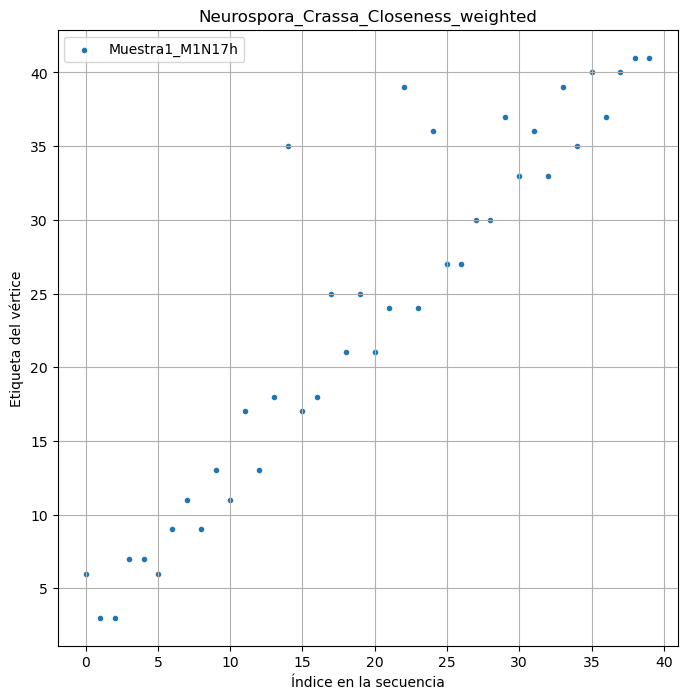

[6, 3, 3, 7, 7, 6, 9, 11, 9, 13, 11, 17, 13, 18, 35, 17, 18, 25, 21, 25, 21, 24, 39, 24, 36, 27, 27, 30, 30, 37, 33, 36, 33, 39, 35, 40, 37, 40, 41, 41]


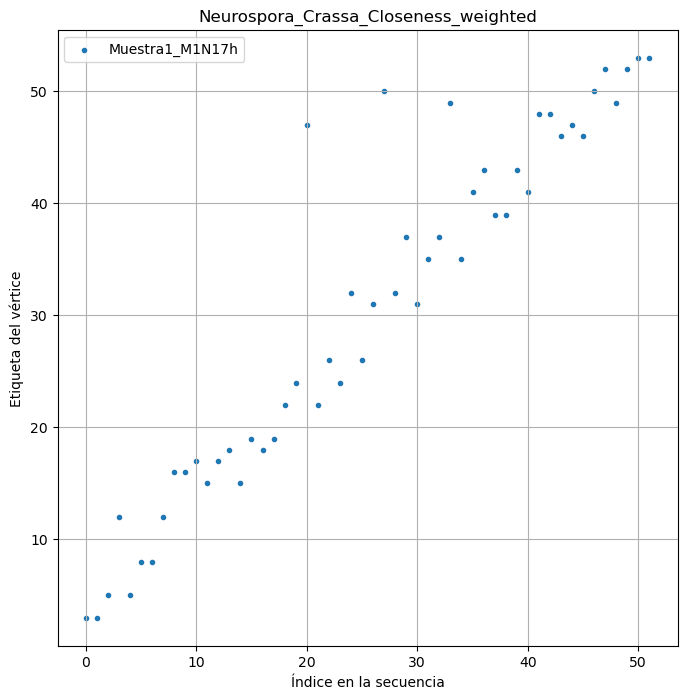

[[3, 3, 5, 12, 5, 8, 8, 12, 16, 16, 17, 15, 17, 18, 15, 19, 18, 19, 22, 24, 47, 22, 26, 24, 32, 26, 31, 50, 32, 37, 31, 35, 37, 49, 35, 41, 43, 39, 39, 43, 41, 48, 48, 46, 47, 46, 50, 52, 49, 52, 53, 53]]
**** Procesando red: Muestra2_M2N18h con 44 nodos y 43 aristas.
Es árbol:  True
**** Procesando red: Muestra2_M2N20h con 110 nodos y 109 aristas.
Es árbol:  True
**** Procesando red: Muestra2_M2N22h con 226 nodos y 228 aristas.
Es árbol:  False
**** Procesando red: Muestra2_M2N24h con 758 nodos y 787 aristas.
Es árbol:  False


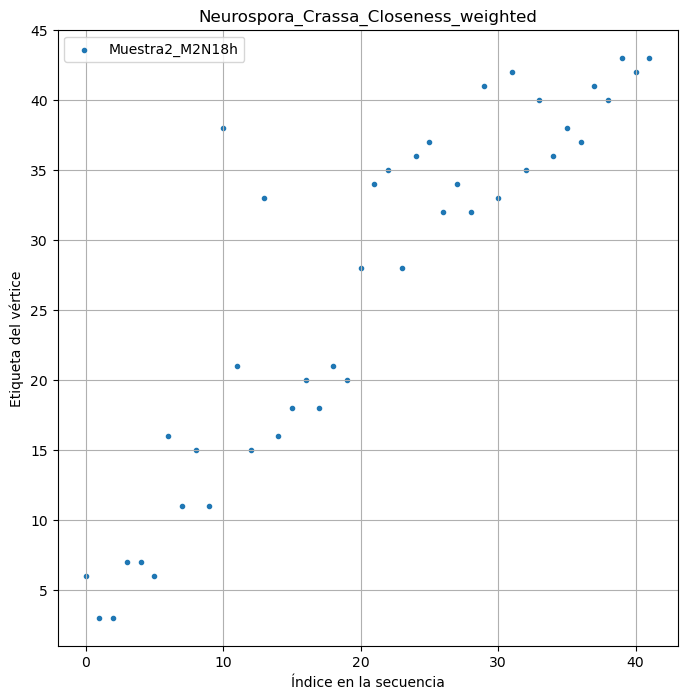

[6, 3, 3, 7, 7, 6, 16, 11, 15, 11, 38, 21, 15, 33, 16, 18, 20, 18, 21, 20, 28, 34, 35, 28, 36, 37, 32, 34, 32, 41, 33, 42, 35, 40, 36, 38, 37, 41, 40, 43, 42, 43]


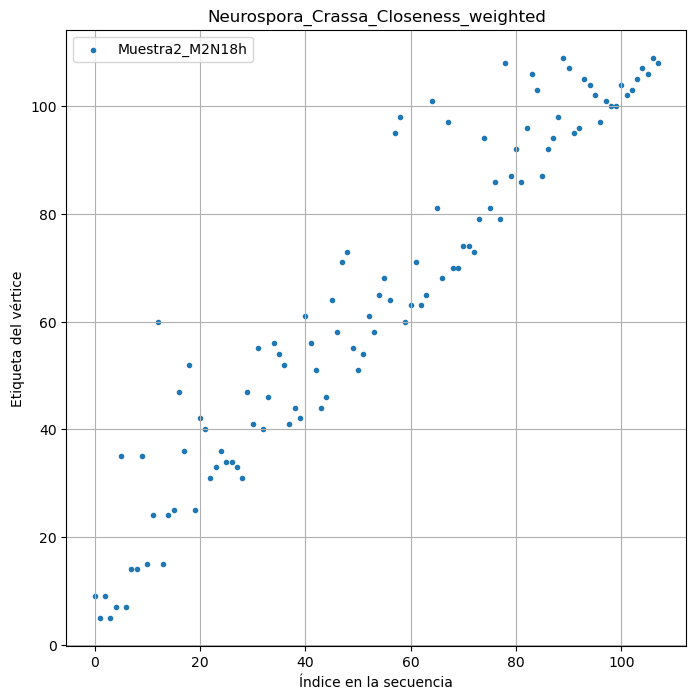

[[9, 5, 9, 5, 7, 35, 7, 14, 14, 35, 15, 24, 60, 15, 24, 25, 47, 36, 52, 25, 42, 40, 31, 33, 36, 34, 34, 33, 31, 47, 41, 55, 40, 46, 56, 54, 52, 41, 44, 42, 61, 56, 51, 44, 46, 64, 58, 71, 73, 55, 51, 54, 61, 58, 65, 68, 64, 95, 98, 60, 63, 71, 63, 65, 101, 81, 68, 97, 70, 70, 74, 74, 73, 79, 94, 81, 86, 79, 108, 87, 92, 86, 96, 106, 103, 87, 92, 94, 98, 109, 107, 95, 96, 105, 104, 102, 97, 101, 100, 100, 104, 102, 103, 105, 107, 106, 109, 108]]
**** Procesando red: Muestra3_M3N17h con 6 nodos y 5 aristas.
Es árbol:  True
**** Procesando red: Muestra3_M3N18h con 24 nodos y 23 aristas.
Es árbol:  True
**** Procesando red: Muestra3_M3N20h con 50 nodos y 49 aristas.
Es árbol:  True
**** Procesando red: Muestra3_M3N22h con 128 nodos y 127 aristas.
Es árbol:  True
**** Procesando red: Muestra3_M3N24h con 338 nodos y 343 aristas.
Es árbol:  False


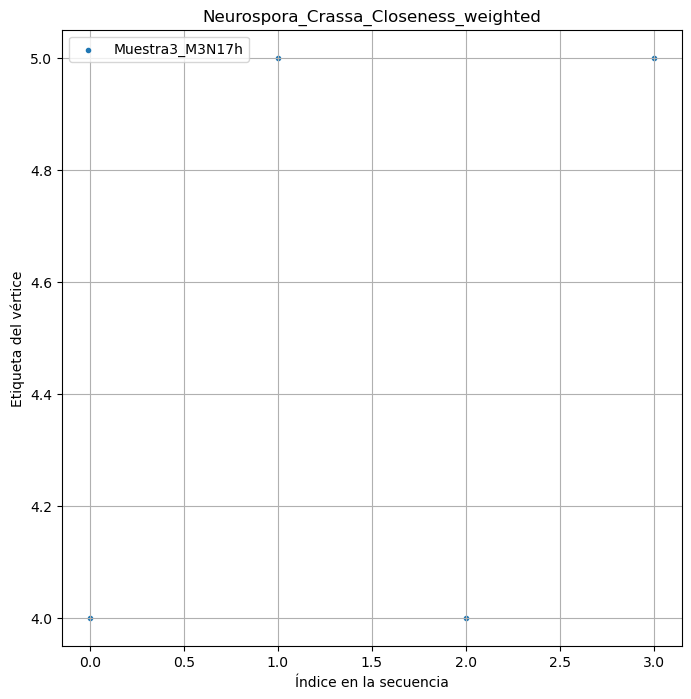

[4, 5, 4, 5]


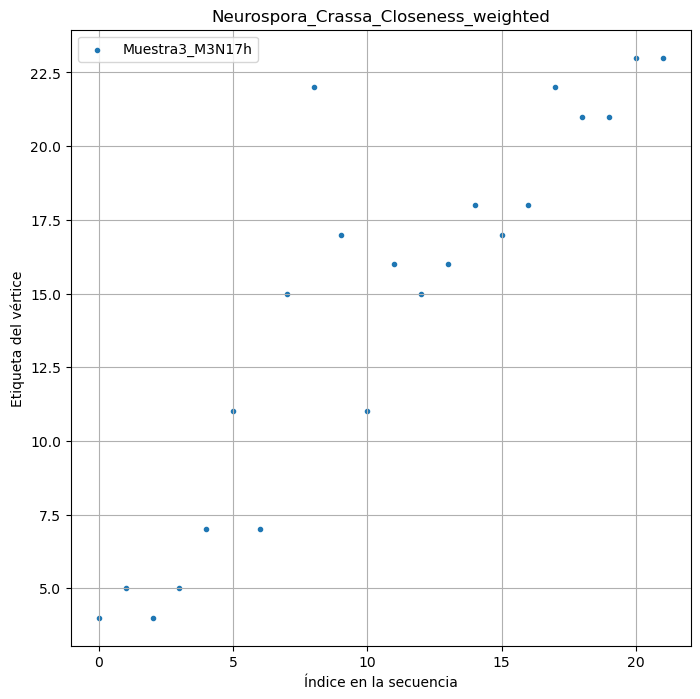

[[4, 5, 4, 5, 7, 11, 7, 15, 22, 17, 11, 16, 15, 16, 18, 17, 18, 22, 21, 21, 23, 23]]
**** Procesando red: Muestra4_M4N17h con 58 nodos y 57 aristas.
Es árbol:  True
**** Procesando red: Muestra4_M4N18h con 84 nodos y 83 aristas.
Es árbol:  True
**** Procesando red: Muestra4_M4N20h con 202 nodos y 202 aristas.
Es árbol:  False
**** Procesando red: Muestra4_M4N22h con 518 nodos y 528 aristas.
Es árbol:  False
**** Procesando red: Muestra4_M4N24h con 1578 nodos y 1657 aristas.
Es árbol:  False


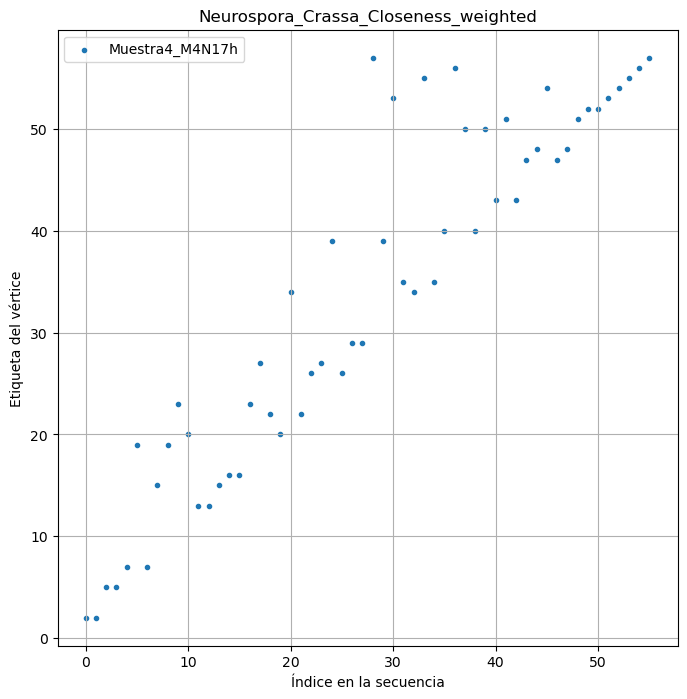

[2, 2, 5, 5, 7, 19, 7, 15, 19, 23, 20, 13, 13, 15, 16, 16, 23, 27, 22, 20, 34, 22, 26, 27, 39, 26, 29, 29, 57, 39, 53, 35, 34, 55, 35, 40, 56, 50, 40, 50, 43, 51, 43, 47, 48, 54, 47, 48, 51, 52, 52, 53, 54, 55, 56, 57]


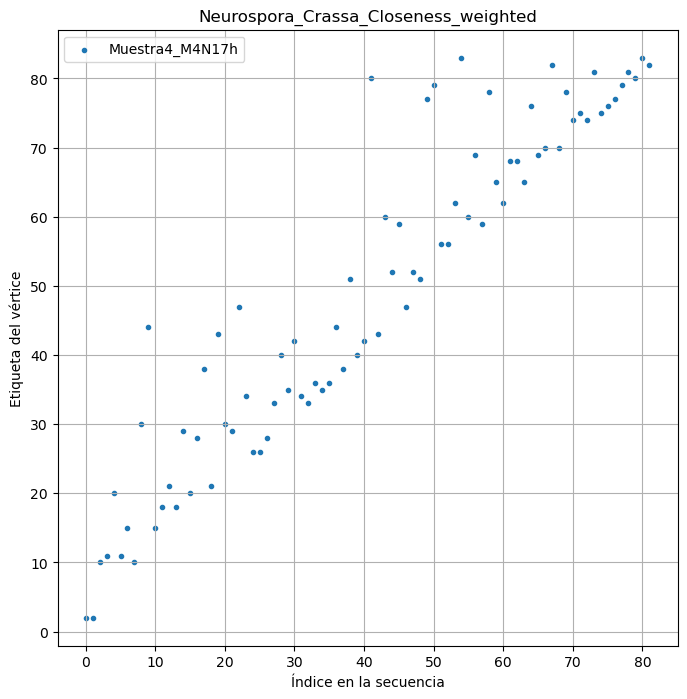

[[2, 2, 10, 11, 20, 11, 15, 10, 30, 44, 15, 18, 21, 18, 29, 20, 28, 38, 21, 43, 30, 29, 47, 34, 26, 26, 28, 33, 40, 35, 42, 34, 33, 36, 35, 36, 44, 38, 51, 40, 42, 80, 43, 60, 52, 59, 47, 52, 51, 77, 79, 56, 56, 62, 83, 60, 69, 59, 78, 65, 62, 68, 68, 65, 76, 69, 70, 82, 70, 78, 74, 75, 74, 81, 75, 76, 77, 79, 81, 80, 83, 82]]
**** Procesando red: Muestra5_M5N18h con 48 nodos y 47 aristas.
Es árbol:  True
**** Procesando red: Muestra5_M5N20h con 100 nodos y 99 aristas.
Es árbol:  True
**** Procesando red: Muestra5_M5N22h con 280 nodos y 288 aristas.
Es árbol:  False
**** Procesando red: Muestra5_M5N24h con 790 nodos y 850 aristas.
Es árbol:  False


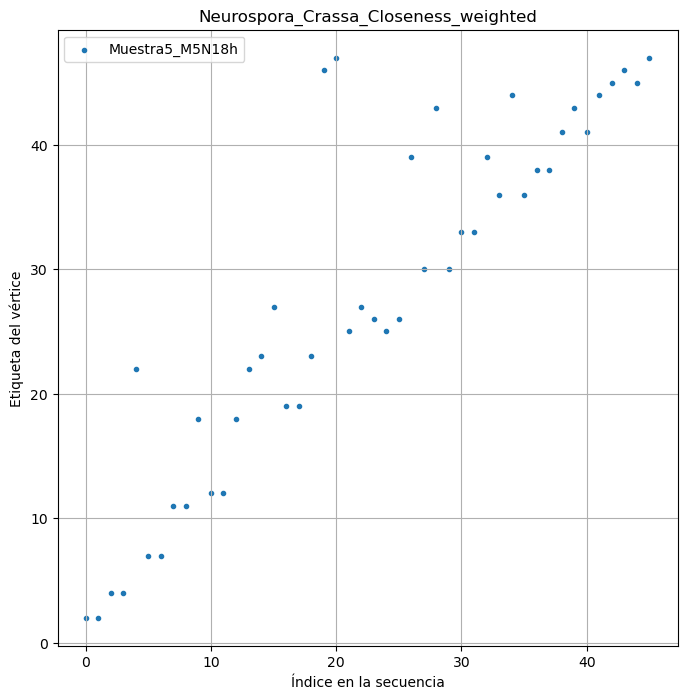

[2, 2, 4, 4, 22, 7, 7, 11, 11, 18, 12, 12, 18, 22, 23, 27, 19, 19, 23, 46, 47, 25, 27, 26, 25, 26, 39, 30, 43, 30, 33, 33, 39, 36, 44, 36, 38, 38, 41, 43, 41, 44, 45, 46, 45, 47]


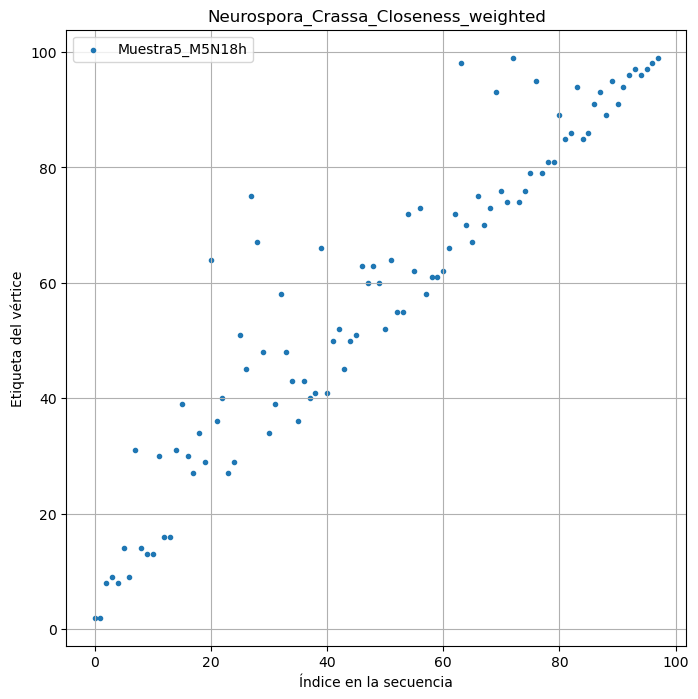

[[2, 2, 8, 9, 8, 14, 9, 31, 14, 13, 13, 30, 16, 16, 31, 39, 30, 27, 34, 29, 64, 36, 40, 27, 29, 51, 45, 75, 67, 48, 34, 39, 58, 48, 43, 36, 43, 40, 41, 66, 41, 50, 52, 45, 50, 51, 63, 60, 63, 60, 52, 64, 55, 55, 72, 62, 73, 58, 61, 61, 62, 66, 72, 98, 70, 67, 75, 70, 73, 93, 76, 74, 99, 74, 76, 79, 95, 79, 81, 81, 89, 85, 86, 94, 85, 86, 91, 93, 89, 95, 91, 94, 96, 97, 96, 97, 98, 99]]


In [18]:
for muestra in range(1,6):
    prufer_seq = list()
    for red in redes[muestra]:
        G = nx.read_gexf(path_red + red + ".gexf")
        print("**** Procesando red:", red, "con", G.number_of_nodes(), "nodos y", G.number_of_edges(), "aristas.")
        print("Es árbol: ", nx.is_tree(G))
        if not nx.is_tree(G):
            T = nx.minimum_spanning_tree(G)
            node_labels = etiquetado_por_centralidad(G, CENTRALIDAD,weighted)
            H=T.copy()
        else:
            node_labels = etiquetado_por_centralidad(G, CENTRALIDAD,weighted)
            H=G.copy()
        if node_labels != None:
            G_relabelled = nx.relabel_nodes(H, node_labels, copy=True)
        else:
            print("No genero etiquetas")
        ps = prufer_sequence_from_tree(G_relabelled.edges())
        pos = {n:(G.nodes[n]['x'],G.nodes[n]['y']) for n in G.nodes()}
        #dibujar_arbol(G, red,pos, node_labels)
        #print("Secuencia de Prüfer:", ps)
        prufer_seq.append(ps)
    #muestra la secuencia de la primera red (0)
    muestra_secuencias([prufer_seq[0]], redes[muestra], titulo)
    print(prufer_seq[0])
    #muestra las secuencias de la segunda y tercer red (1 y 2)
    muestra_secuencias(prufer_seq[1:2], redes[muestra], titulo)
    print(prufer_seq[1:2])


## Secuencia de un árbol aleatorio

**** Procesando árbol aleatorio con 42 nodos y 41 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 54 nodos y 53 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 102 nodos y 101 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 226 nodos y 225 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 663 nodos y 662 aristas.
Es árbol:  True


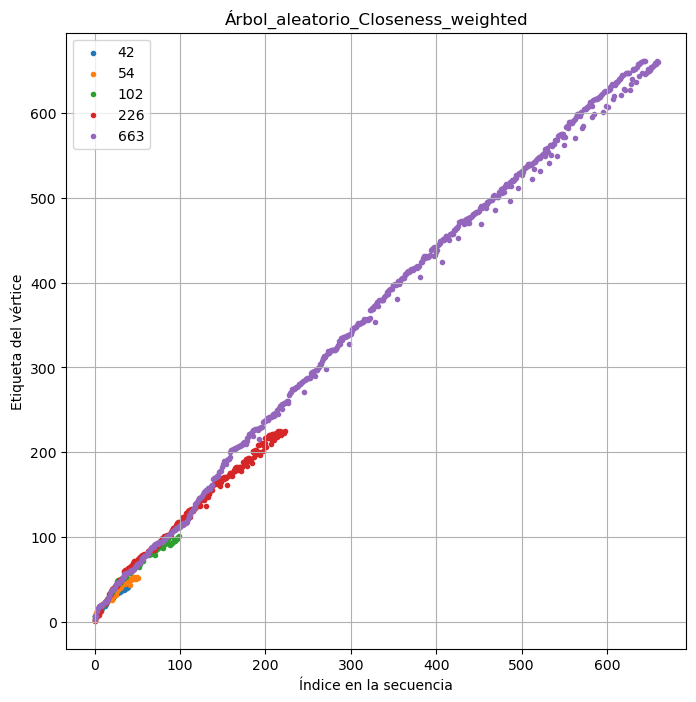

**** Procesando árbol aleatorio con 44 nodos y 43 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 110 nodos y 109 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 226 nodos y 225 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 758 nodos y 757 aristas.
Es árbol:  True


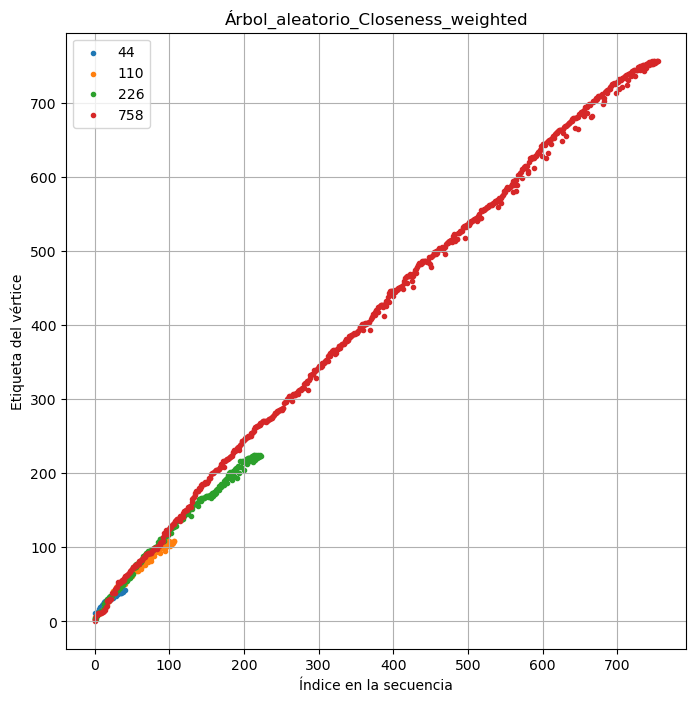

**** Procesando árbol aleatorio con 6 nodos y 5 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 24 nodos y 23 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 50 nodos y 49 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 128 nodos y 127 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 338 nodos y 337 aristas.
Es árbol:  True


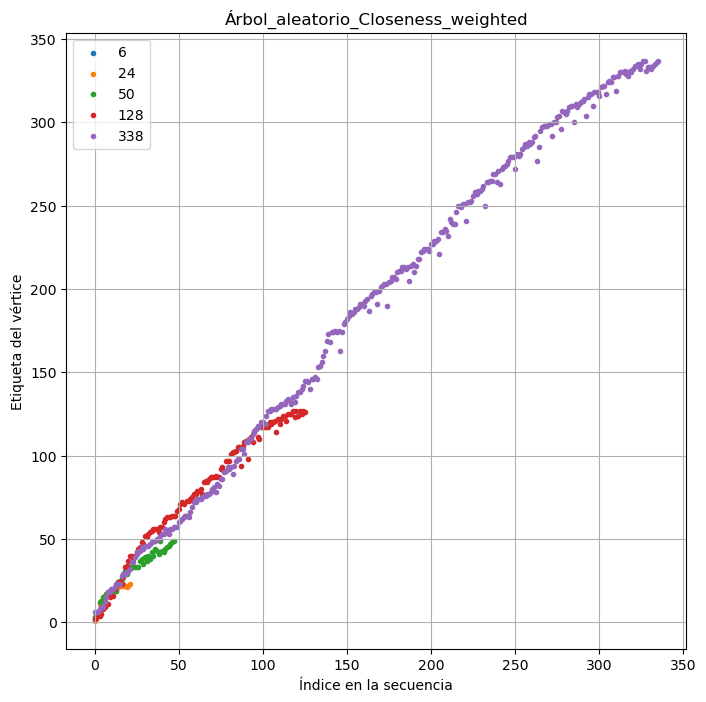

**** Procesando árbol aleatorio con 58 nodos y 57 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 84 nodos y 83 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 202 nodos y 201 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 518 nodos y 517 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 1578 nodos y 1577 aristas.
Es árbol:  True


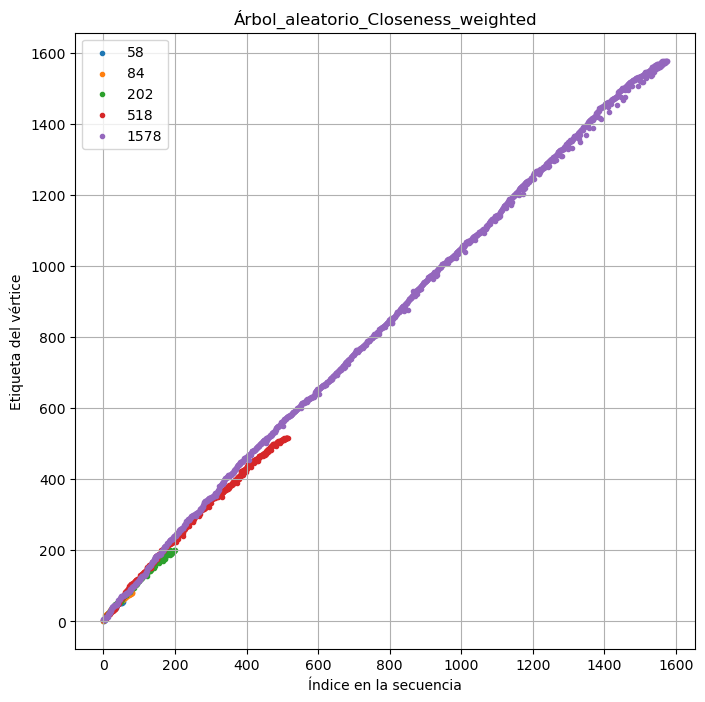

**** Procesando árbol aleatorio con 48 nodos y 47 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 100 nodos y 99 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 280 nodos y 279 aristas.
Es árbol:  True
**** Procesando árbol aleatorio con 790 nodos y 789 aristas.
Es árbol:  True


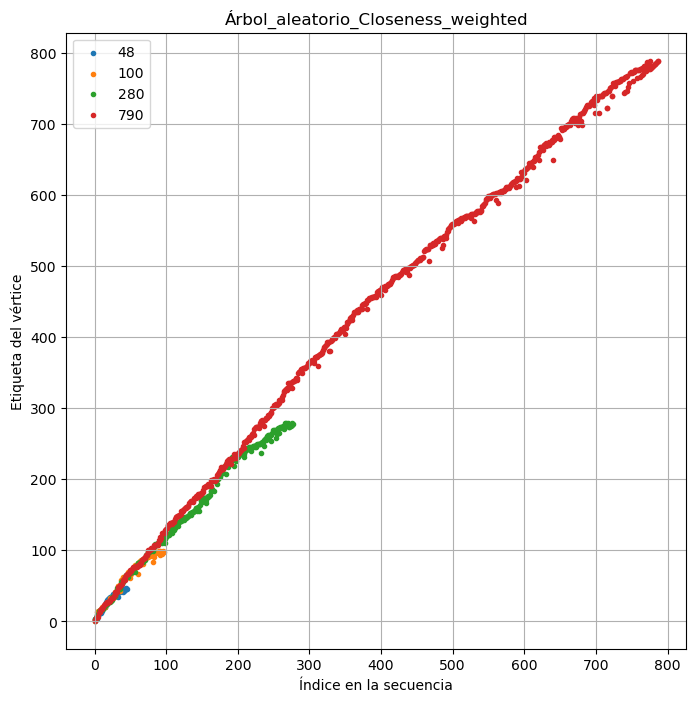

In [14]:
for muestra in range(1,6):
    prufer_seq = list()
    for n in nodos_red[muestra]:
        G = nx.generators.random_tree(n)
        print("**** Procesando árbol aleatorio con", G.number_of_nodes(), "nodos y", G.number_of_edges(), "aristas.")
        print("Es árbol: ", nx.is_tree(G))
        node_labels = etiquetado_por_centralidad(G, CENTRALIDAD, weighted)
        G_relabelled = nx.relabel_nodes(G, node_labels, copy=True)
        ps = prufer_sequence_from_tree(G_relabelled.edges())
        #dibujar_arbol(G, red,pos, node_labels)
        #print("Secuencia de Prüfer:", ps)
        prufer_seq.append(ps)
    muestra_secuencias(prufer_seq, nodos_red[muestra], "Árbol_aleatorio")

**** Procesando red: Muestra5_M5T36h con 13 nodos y 12 aristas.
Es árbol:  True


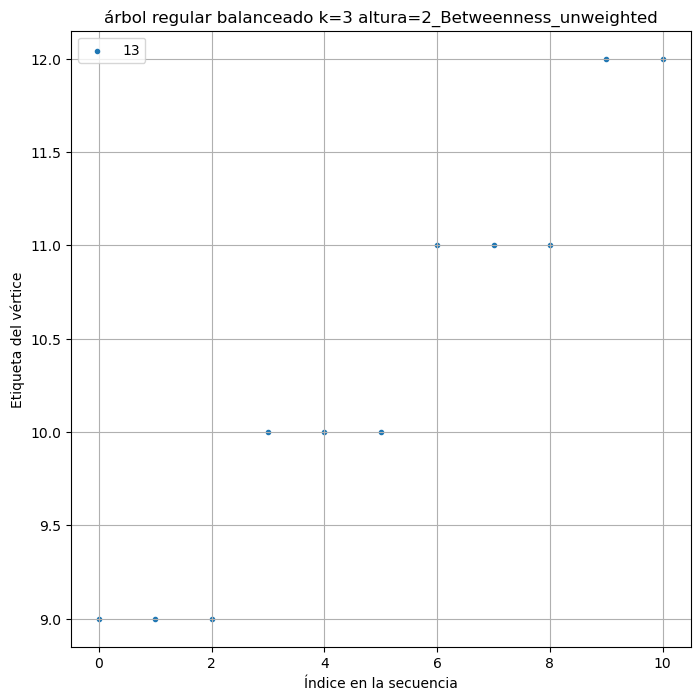

In [145]:
k=3
altura=2
G = generar_arbol_regular_balanceado(k, altura)
n = G.number_of_nodes()
print("**** Procesando red:", red, "con", n, "nodos y", G.number_of_edges(), "aristas.")
print("Es árbol: ", nx.is_tree(G))
node_labels = etiquetado_por_centralidad(G, CENTRALIDAD, weighted)
G_relabelled = nx.relabel_nodes(G, node_labels, copy=True)
ps = prufer_sequence_from_tree(G_relabelled.edges())
#dibujar_arbol(G, red,pos, node_labels)
#print("Secuencia de Prüfer:", ps)
muestra_secuencias([ps],[n], "árbol regular balanceado k=" + str(k) + " altura=" + str(altura))

In [51]:
import random
def sample_with_replacement(population, k):
    """Returns a sample of size ``k`` from the given population.

    ``population`` must be a sequence and ``k`` must be a positive
    integer.

    This function returns a list of ``k`` elements chosen uniformly at
    random from ``population``.

    """
    return [random.choice(population) for i in range(k)]
n= 10
sequence = sample_with_replacement(range(n), n - 2)
print("Secuencia de Prüfer aleatoria:", sequence)
T = nx.from_prufer_sequence(sequence)
diametro = nx.diameter(T)
print("Diámetro del árbol generado a partir de la secuencia de Prüfer aleatoria:", diametro)
for i in range(1,100):
    x = sequence.count(i)
    if x > 3:
        print("Cuántos ", i ," hay ", sequence.count(i))

Secuencia de Prüfer aleatoria: [3, 2, 4, 3, 1, 6, 7, 7]
Diámetro del árbol generado a partir de la secuencia de Prüfer aleatoria: 7
